# User Behaviour Analysis Based on Borrowing Dates

The aim of the notebook is to analyze user behavior based on the date of borrowing in order to create a kind of user profile. The following questions should be answered:
1. Do users have a routine when visiting the library? This initially refers to the day of the week on which users borrow items. Can consistency be identified on a particular day?
2. Can a more detailed user type be identified by including the time of day?

In [204]:
%config InlineBackend.figure_format = 'retina'

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import setup_pandas, setup_plotting


# --- global notebook setup (pandas + tueplots/matplotlib style) ---
setup_pandas()
setup_plotting()


# --- project paths ---
PROCESSED_DATA_PATH = Path('../dat/processed')
CLEANED_FILE = PROCESSED_DATA_PATH / "borrowings_2019_2025_cleaned.csv"


In [205]:
# --- load data ---

borrowings = pd.read_csv(
    CLEANED_FILE,
    sep=";",
    quotechar='"',
    encoding="utf-8"
)

print("Loaded shape:", borrowings.shape)

Loaded shape: (2313072, 21)


In [206]:
# --- preprocess relevant columns ---

# column names
ISSUE_COL = "Ausleihdatum/Uhrzeit"

USER_ID_COL = "Benutzer-Systemnummer"
USER_CATEGORY_COL = "Benutzerkategorie"

LATE_FLAG_COL = "Verspätet"

borrowings[USER_ID_COL] = pd.to_numeric(borrowings[USER_ID_COL], errors="coerce").astype("Int64")

borrowings[ISSUE_COL] = pd.to_datetime(borrowings[ISSUE_COL], errors="coerce")

# normalize late flag to boolean (Ja/Nein -> True/False); keep unknown as <NA>
if LATE_FLAG_COL in borrowings.columns:
    v = borrowings[LATE_FLAG_COL].astype(str).str.strip().str.lower()
    borrowings["late_bool"] = pd.Series(np.where(v == "ja", True, np.where(v == "nein", False, pd.NA)), dtype="boolean")



## Analysis of user routine and weekday consistency

### Collecting multiple loans into sessions
All loans by a user on a day make up a session.

In [207]:

df_sessions = borrowings.copy()
df_sessions["session_time"] = df_sessions[ISSUE_COL].dt.floor("D")

user_sessions = df_sessions.groupby([USER_ID_COL, "session_time"]).size().reset_index(name="items_borrowed")
user_sessions["weekday"] = user_sessions["session_time"].dt.day_name()


In [208]:
MIN_SESSIONS = 10
session_day_counts = user_sessions.groupby([USER_ID_COL, 'weekday']).size().unstack(fill_value=0)

# Top-Day-Percentage based on visits
session_consistency = (session_day_counts.max(axis=1) / session_day_counts.sum(axis=1)) * 100

frequent_user_mask = session_day_counts.sum(axis=1) >= MIN_SESSIONS
clean_consistency = session_consistency[frequent_user_mask]

print(f"Based on {len(clean_consistency)} users with >= {MIN_SESSIONS} visits.")
print(clean_consistency.describe())

Based on 9574 users with >= 10 visits.
count   9,574.0000
mean       37.8596
std        11.8800
min        18.1818
25%        29.6296
50%        35.1852
75%        42.8571
max       100.0000
dtype: float64


In [209]:
session_day_counts.head()

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
Benutzer-Systemnummer,,,,,,,
46,3,0,0,0,0,0,0
50,104,30,51,0,125,181,150
51,2,0,1,0,6,6,1
53,0,0,0,0,2,1,0
54,50,4,43,0,40,48,47


Quantify user routine by calculating the distribution of visits across weekdays and identifying the share of visits occurring on the most frequent day (Favorite Day Consistency)

The mean consistency of 42.8% indicates that, on average users perform nearly half of their borrowing sessions on their most preferred weekday. Compared to a theoretical random distribution of 20% (assuming 5 opening days), this could suggest a behavioral routine among frequent users

/var/folders/zr/spgxm1td597dgv39lljd_8tr0000gn/T/ipykernel_31986/497821977.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


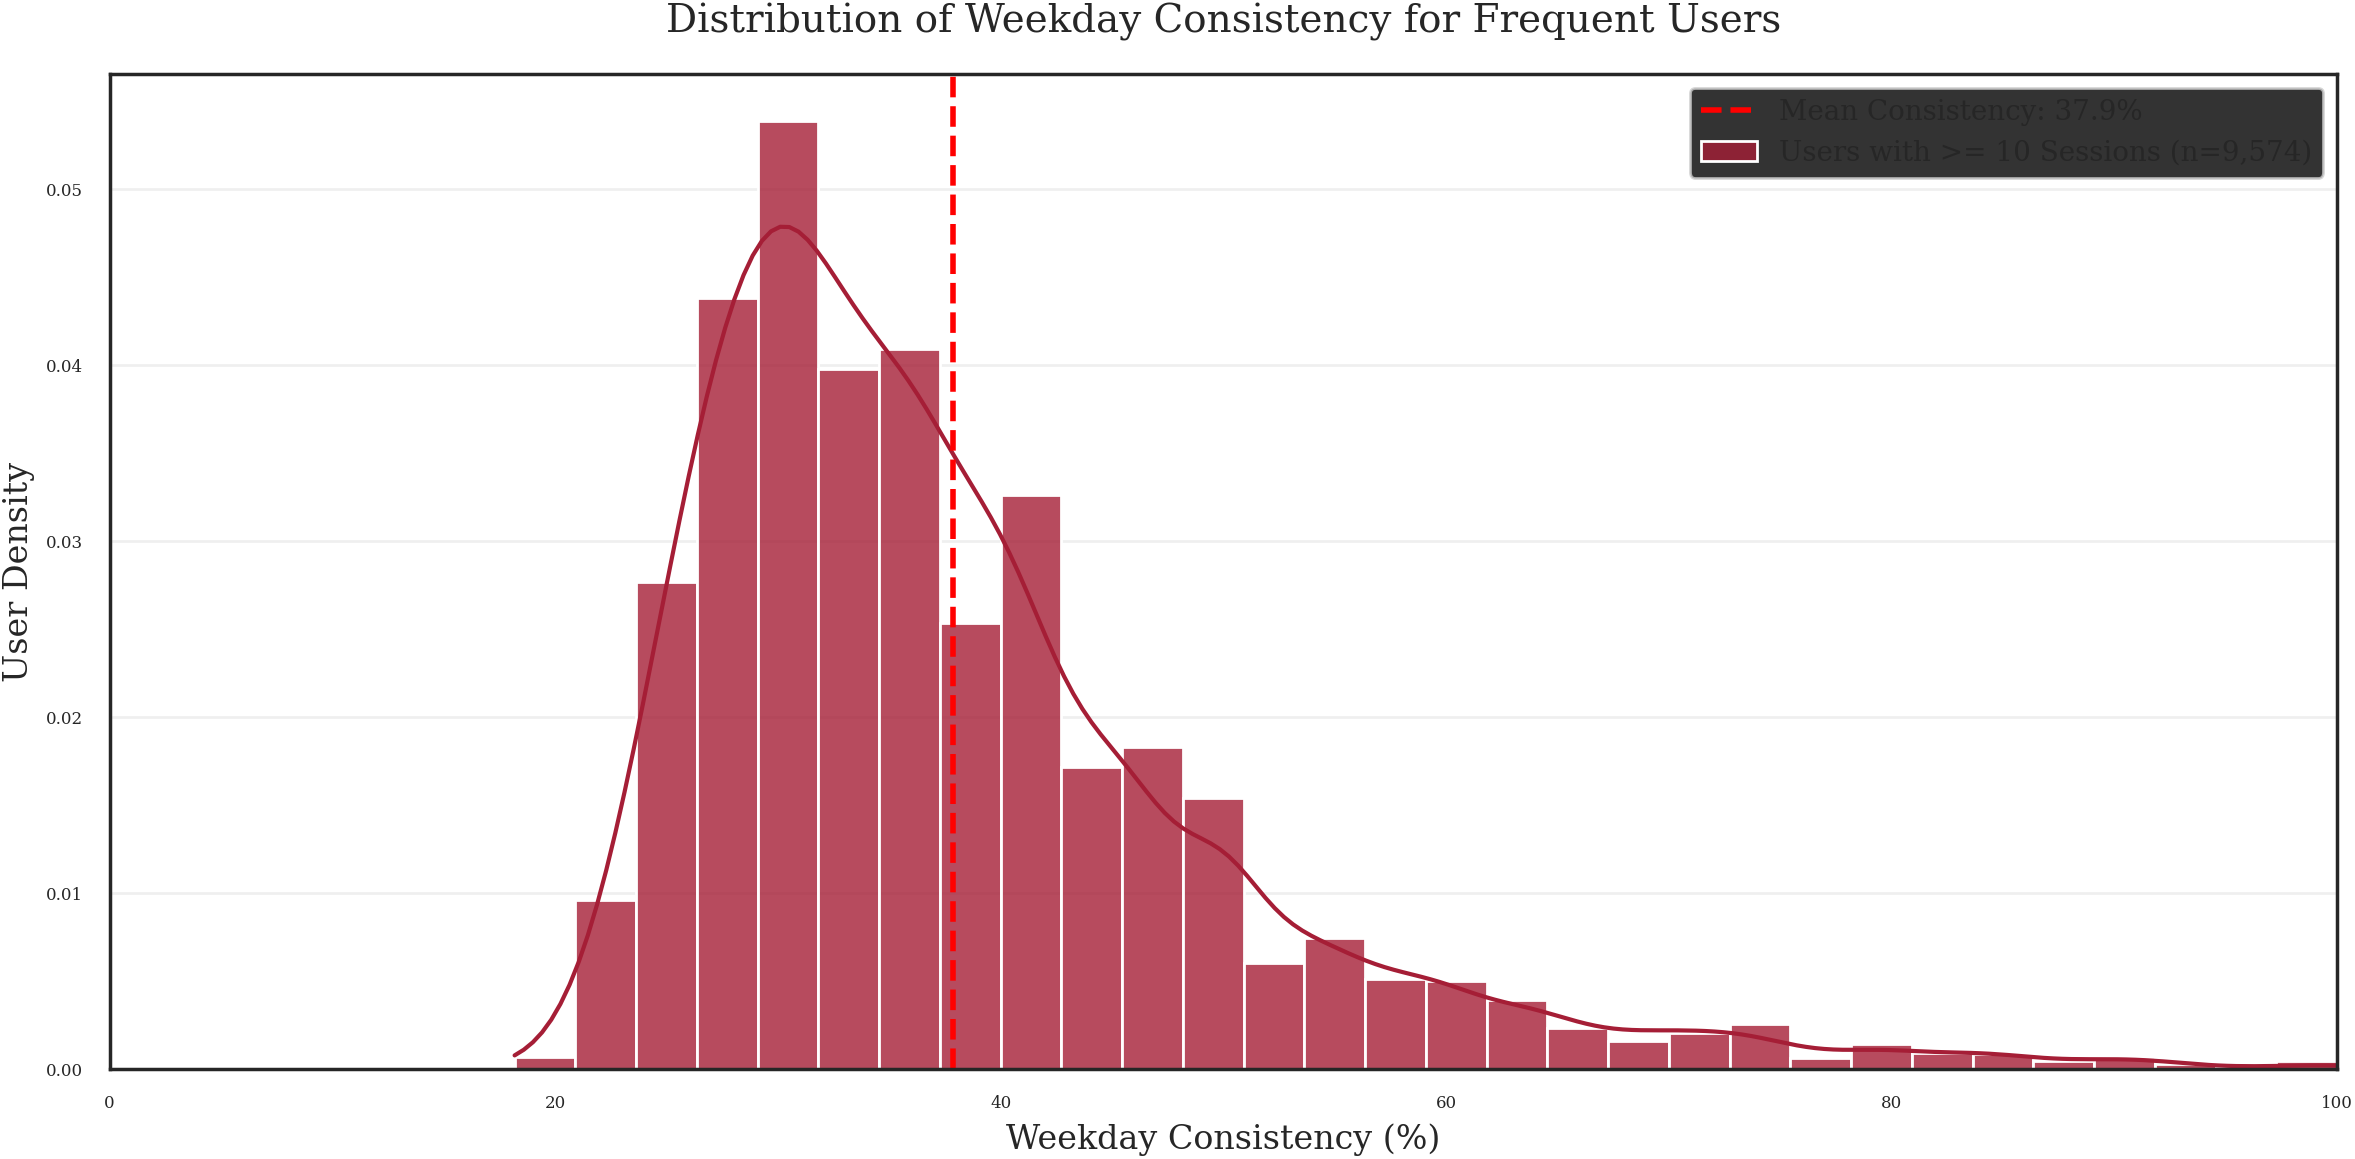

In [210]:

mean_val = clean_consistency.mean()

plt.figure(figsize=(12, 6))

sns.histplot(
    clean_consistency, 
    bins=30, 
    kde=True, 
    alpha=0.8, 
    label=f'Users with >= {MIN_SESSIONS} Sessions (n={len(clean_consistency):,})', 
    stat="density", 
    common_norm=False
)

plt.axvline(
    mean_val, 
    color='red', 
    linestyle='--', 
    linewidth=2, 
    label=f'Mean Consistency: {mean_val:.1f}%'
)

plt.title('Distribution of Weekday Consistency for Frequent Users', fontsize=14, pad=15)
plt.xlabel('Weekday Consistency (%)', fontsize=12)
plt.ylabel('User Density', fontsize=12)

plt.xlim(0, 100)
plt.legend(fontsize=10)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

The distribution would also enable a possible grouping of users based on their consistency.


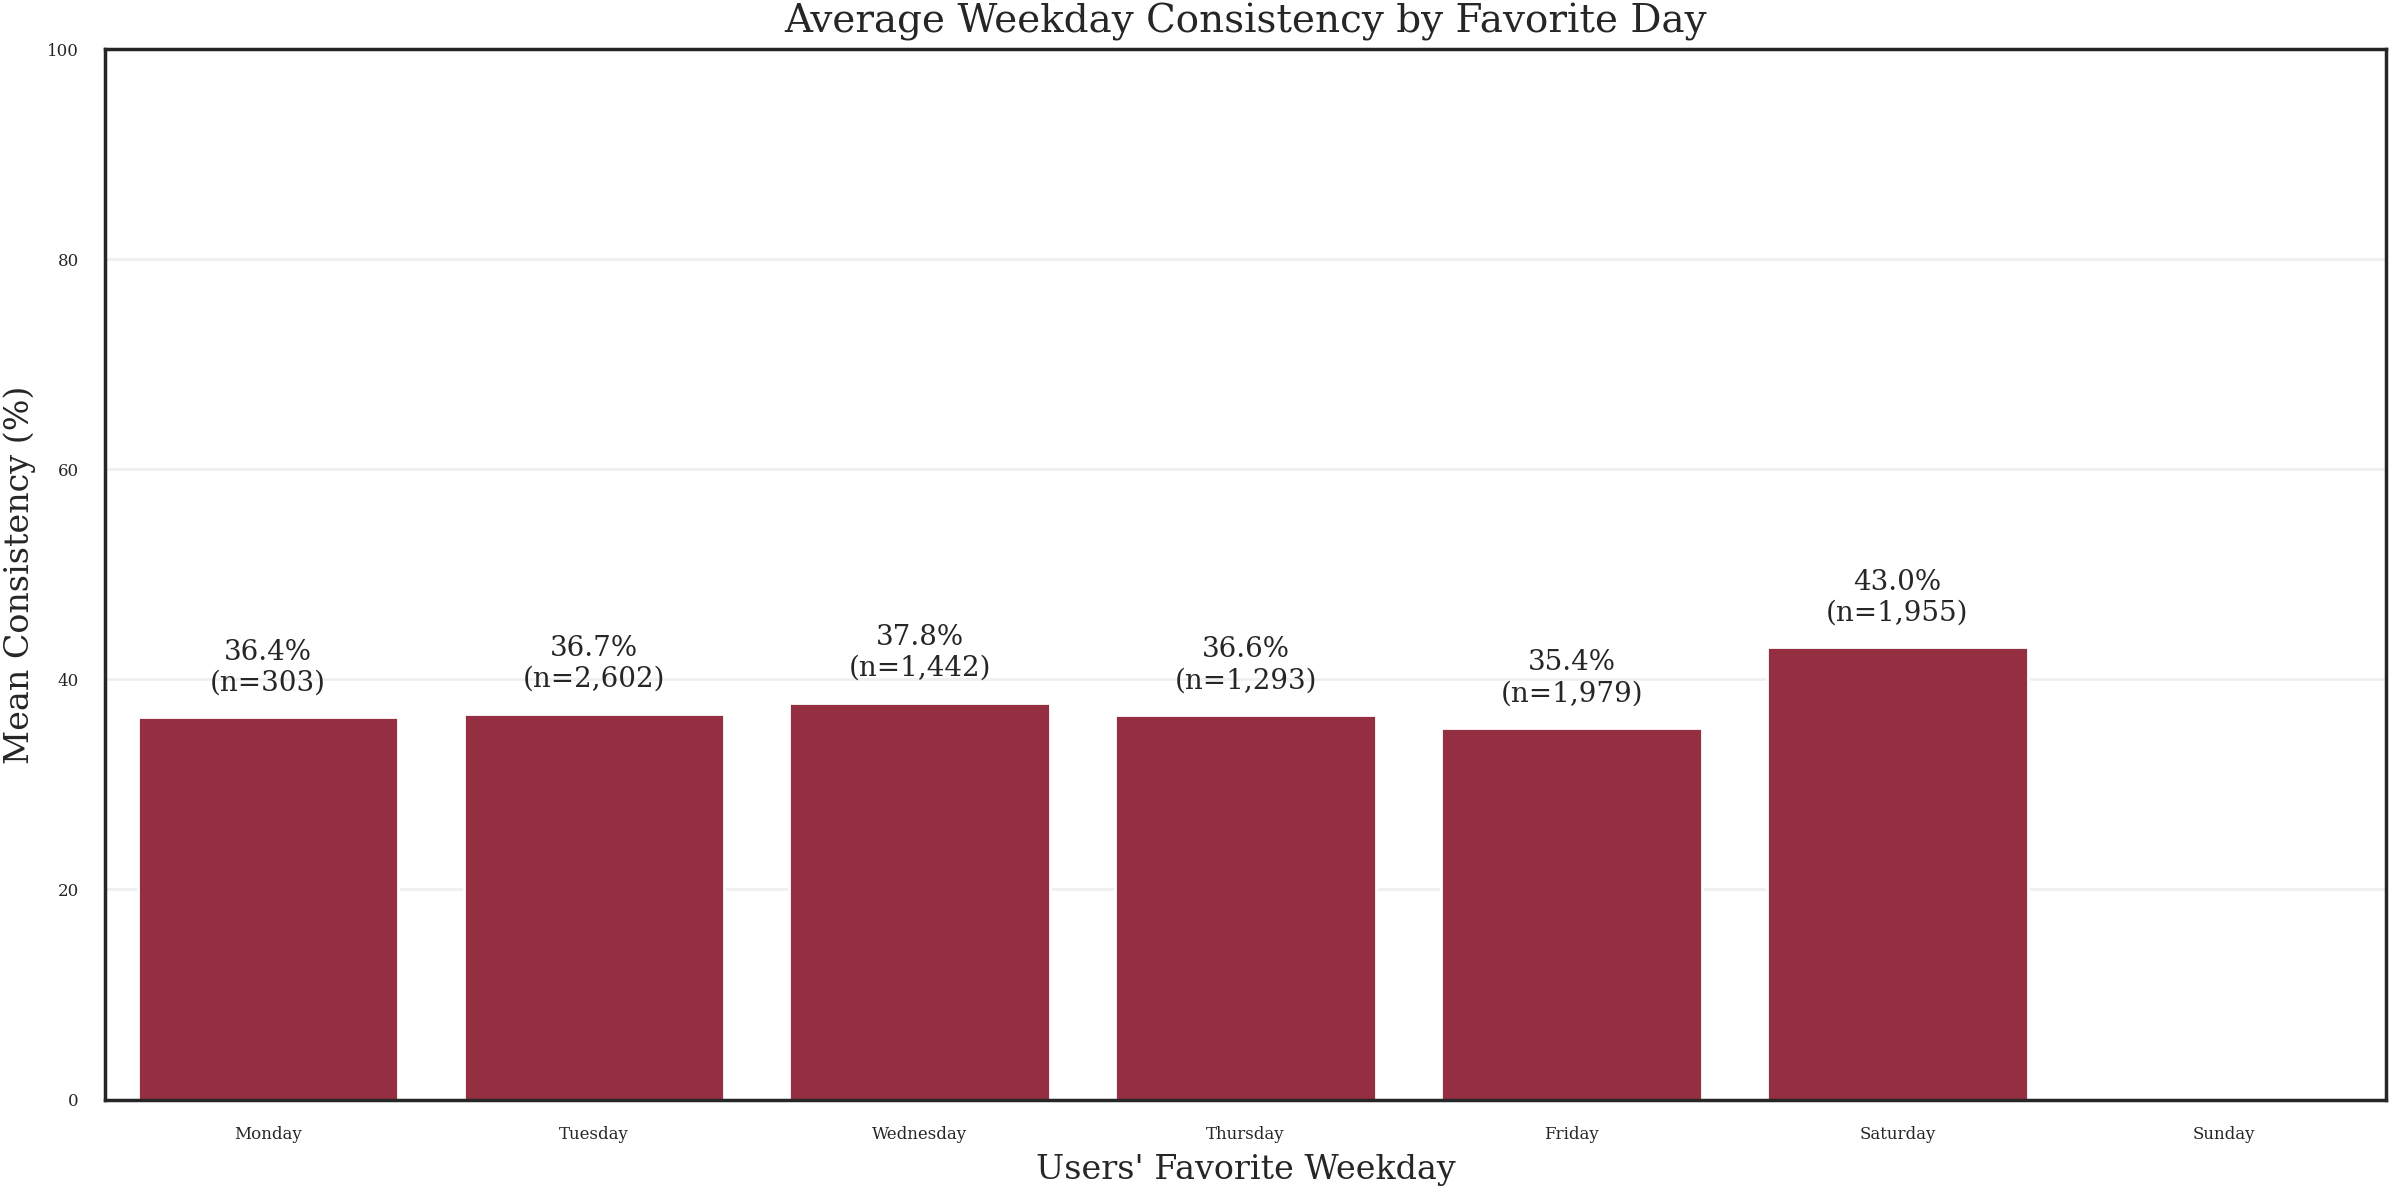

In [211]:
# Identify the favorite day for each user
favorite_days = session_day_counts.idxmax(axis=1)
favorite_days_df = favorite_days.to_frame(name='favorite_weekday')

# Merge with consistency metrics
consistency_comparison = favorite_days_df.merge(
    clean_consistency.to_frame(name='consistency'), 
    left_index=True, 
    right_index=True
)

#Calculate average consistency per favorite day
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_stats = (
    consistency_comparison.groupby('favorite_weekday')['consistency']
    .agg(['mean', 'count'])
    .reindex(day_order)
)

plt.figure(figsize=(12, 6))
sns.barplot(
    x=day_stats.index, 
    y=day_stats['mean'], 
)

plt.title('Average Weekday Consistency by Favorite Day', fontsize=14)
plt.xlabel('Users\' Favorite Weekday', fontsize=12)
plt.ylabel('Mean Consistency (%)', fontsize=12)
plt.ylim(0, 100)

for i, row in enumerate(day_stats.itertuples()):
    if not pd.isna(row.mean):
        plt.text(i, row.mean + 2, f"{row.mean:.1f}%\n(n={int(row.count):,})", 
                 ha='center', va='bottom', fontsize=10)
plt.grid(axis='y', alpha=0.3)
plt.show()

No matter what day of the week, users show a steady level of consistency.

## Analysis of borrowing time

Define sessions over time slots

In [212]:
df_time = borrowings.copy()
# Sort by user and time to calculate gaps correctly
df_time = df_time.sort_values(by=[USER_ID_COL, ISSUE_COL])

# Identify new sessions (gap > 30 minutes)
df_time['time_diff'] = df_time.groupby(USER_ID_COL)[ISSUE_COL].diff()
MAX_GAP = pd.Timedelta(minutes=30)
df_time['is_new_session'] = (df_time['time_diff'] > MAX_GAP) | (df_time['time_diff'].isna())
df_time['session_id'] = df_time.groupby(USER_ID_COL)['is_new_session'].cumsum()

# Aggregate to session level
user_sessions = df_time.groupby([USER_ID_COL, 'session_id']).agg({
    ISSUE_COL: 'first',
    USER_CATEGORY_COL: 'first', # Added user category
    'late_bool': 'max',
    'is_new_session': 'size'    # Count rows per session
}).reset_index()

# Rename and create temporal features
user_sessions = user_sessions.rename(columns={'is_new_session': 'items_count'})
user_sessions["weekday"] = user_sessions[ISSUE_COL].dt.day_name()
user_sessions["hour"] = user_sessions[ISSUE_COL].dt.hour
user_sessions["seconds_since_midnight"] = (
    user_sessions[ISSUE_COL].dt.hour * 3600 +
    user_sessions[ISSUE_COL].dt.minute * 60 +
    user_sessions[ISSUE_COL].dt.second
)
user_sessions["precise_hour"] = user_sessions["seconds_since_midnight"] / 3600

user_sessions["date"] = user_sessions[ISSUE_COL].dt.date



In [213]:
user_sessions.head()

,Benutzer-Systemnummer,session_id,Ausleihdatum/Uhrzeit,Benutzerkategorie,late_bool,items_count,weekday,hour,seconds_since_midnight,precise_hour,date
0,46,1.0000,2019-05-31 10:34:21,INS,True,1,Friday,10,38061,10.5725,2019-05-31
1,46,2.0000,2023-03-10 10:17:05,INS,False,1,Friday,10,37025,10.2847,2023-03-10
2,46,3.0000,2023-10-13 11:54:15,INS,False,1,Friday,11,42855,11.9042,2023-10-13
3,50,1.0000,2019-01-02 00:00:00,MPA,False,4,Wednesday,0,0,0.0000,2019-01-02
4,50,2.0000,2019-01-03 00:00:00,MPA,False,1,Thursday,0,0,0.0000,2019-01-03


Remove outliers and apply minimum number of sessions for analysis

In [214]:
# Check for midnight outliers
midnight_sessions = user_sessions[
    (user_sessions[ISSUE_COL].dt.hour == 0) & 
    (user_sessions[ISSUE_COL].dt.minute == 0) & 
    (user_sessions[ISSUE_COL].dt.second == 0)
]

print(f"Sessions at exactly midnight: {len(midnight_sessions)}")

# Filter them out for the hourly analysis
user_sessions_clean = user_sessions[~(
    (user_sessions[ISSUE_COL].dt.hour == 0) & 
    (user_sessions[ISSUE_COL].dt.minute == 0)
)].copy()

print(f"Remaining sessions for without midnight outliers: {len(user_sessions_clean)}")

user_counts = user_sessions_clean.groupby(USER_ID_COL).size()
frequent_user_ids = user_counts[user_counts >= MIN_SESSIONS].index

user_sessions_clean = user_sessions_clean[user_sessions_clean[USER_ID_COL].isin(frequent_user_ids)].copy()


print(f"Analyzing {len(frequent_user_ids)} users with at least {MIN_SESSIONS} visits and in total {len(user_sessions_clean)}.")


Sessions at exactly midnight: 7
Remaining sessions for without midnight outliers: 451632
Analyzing 9637 users with at least 10 visits and in total 411059.


### Library usage on a specific day 

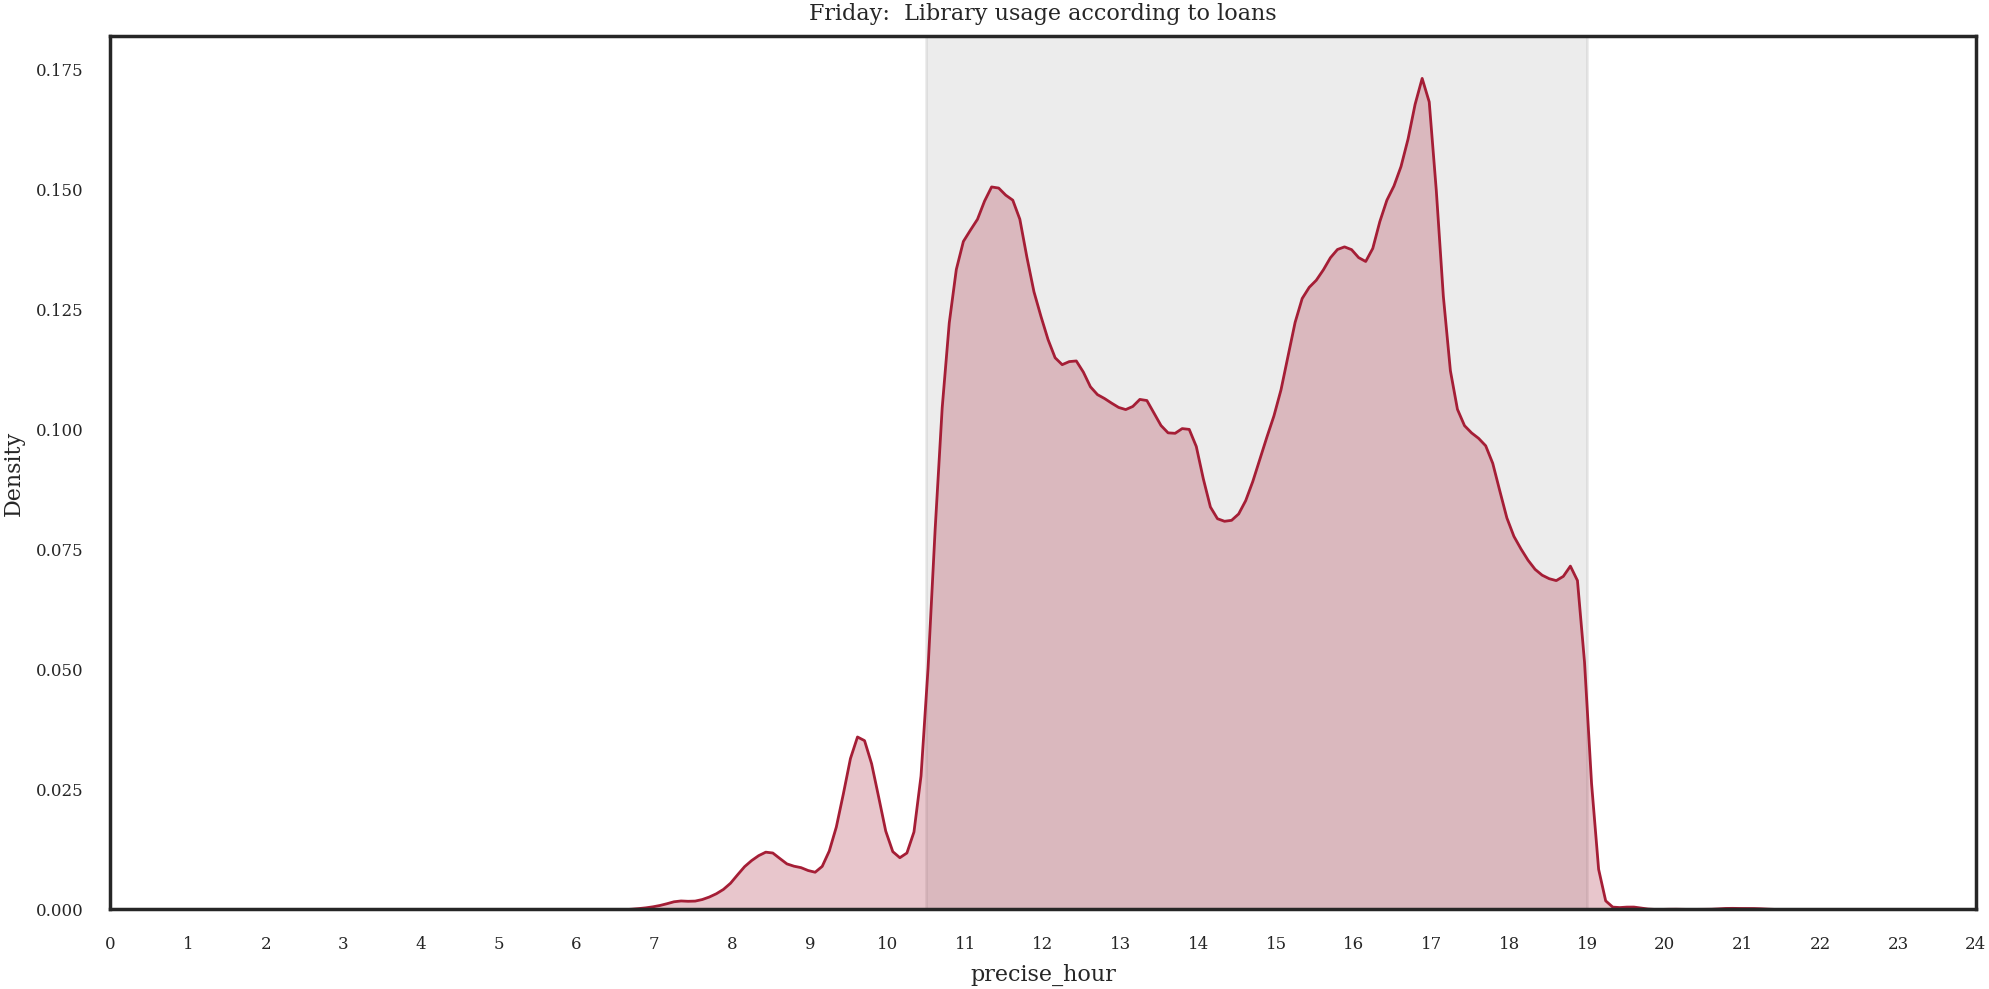

In [215]:

DAY = "Friday"
day_data = user_sessions_clean[user_sessions_clean["weekday"] == DAY]

plt.figure(figsize=(10, 5))
plt.axvspan(10.5, 19.0, color='gray', alpha=0.15, label='Official Opening Hours')

sns.kdeplot(
    data=day_data, 
    x="precise_hour", 
    fill=True, 
    bw_adjust=0.4, 
)

plt.xlim(0, 24)
plt.xticks(range(0, 25))
plt.title(f"{DAY}:  Library usage according to loans")
plt.show()

### Analysis of average loan time per user

In [216]:
# Calculate average time per user
user_time_behavior = user_sessions_clean.groupby(USER_ID_COL).agg({
    'precise_hour': ['mean', 'std', 'count'], 
    'weekday': lambda x: x.mode()[0] if not x.mode().empty else "Unknown" 
})
user_time_behavior.columns = ['avg_hour', 'hour_spread', 'visit_count', 'fav_day']

In [217]:
user_time_behavior.head()

,avg_hour,hour_spread,visit_count,fav_day
Benutzer-Systemnummer,,,,
50,12.2264,3.0660,844,Tuesday
51,14.6385,2.1495,16,Thursday
54,13.1136,2.1026,235,Friday
55,12.9809,2.2634,150,Tuesday
57,15.7957,2.1796,208,Tuesday


/var/folders/zr/spgxm1td597dgv39lljd_8tr0000gn/T/ipykernel_31986/3143622496.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


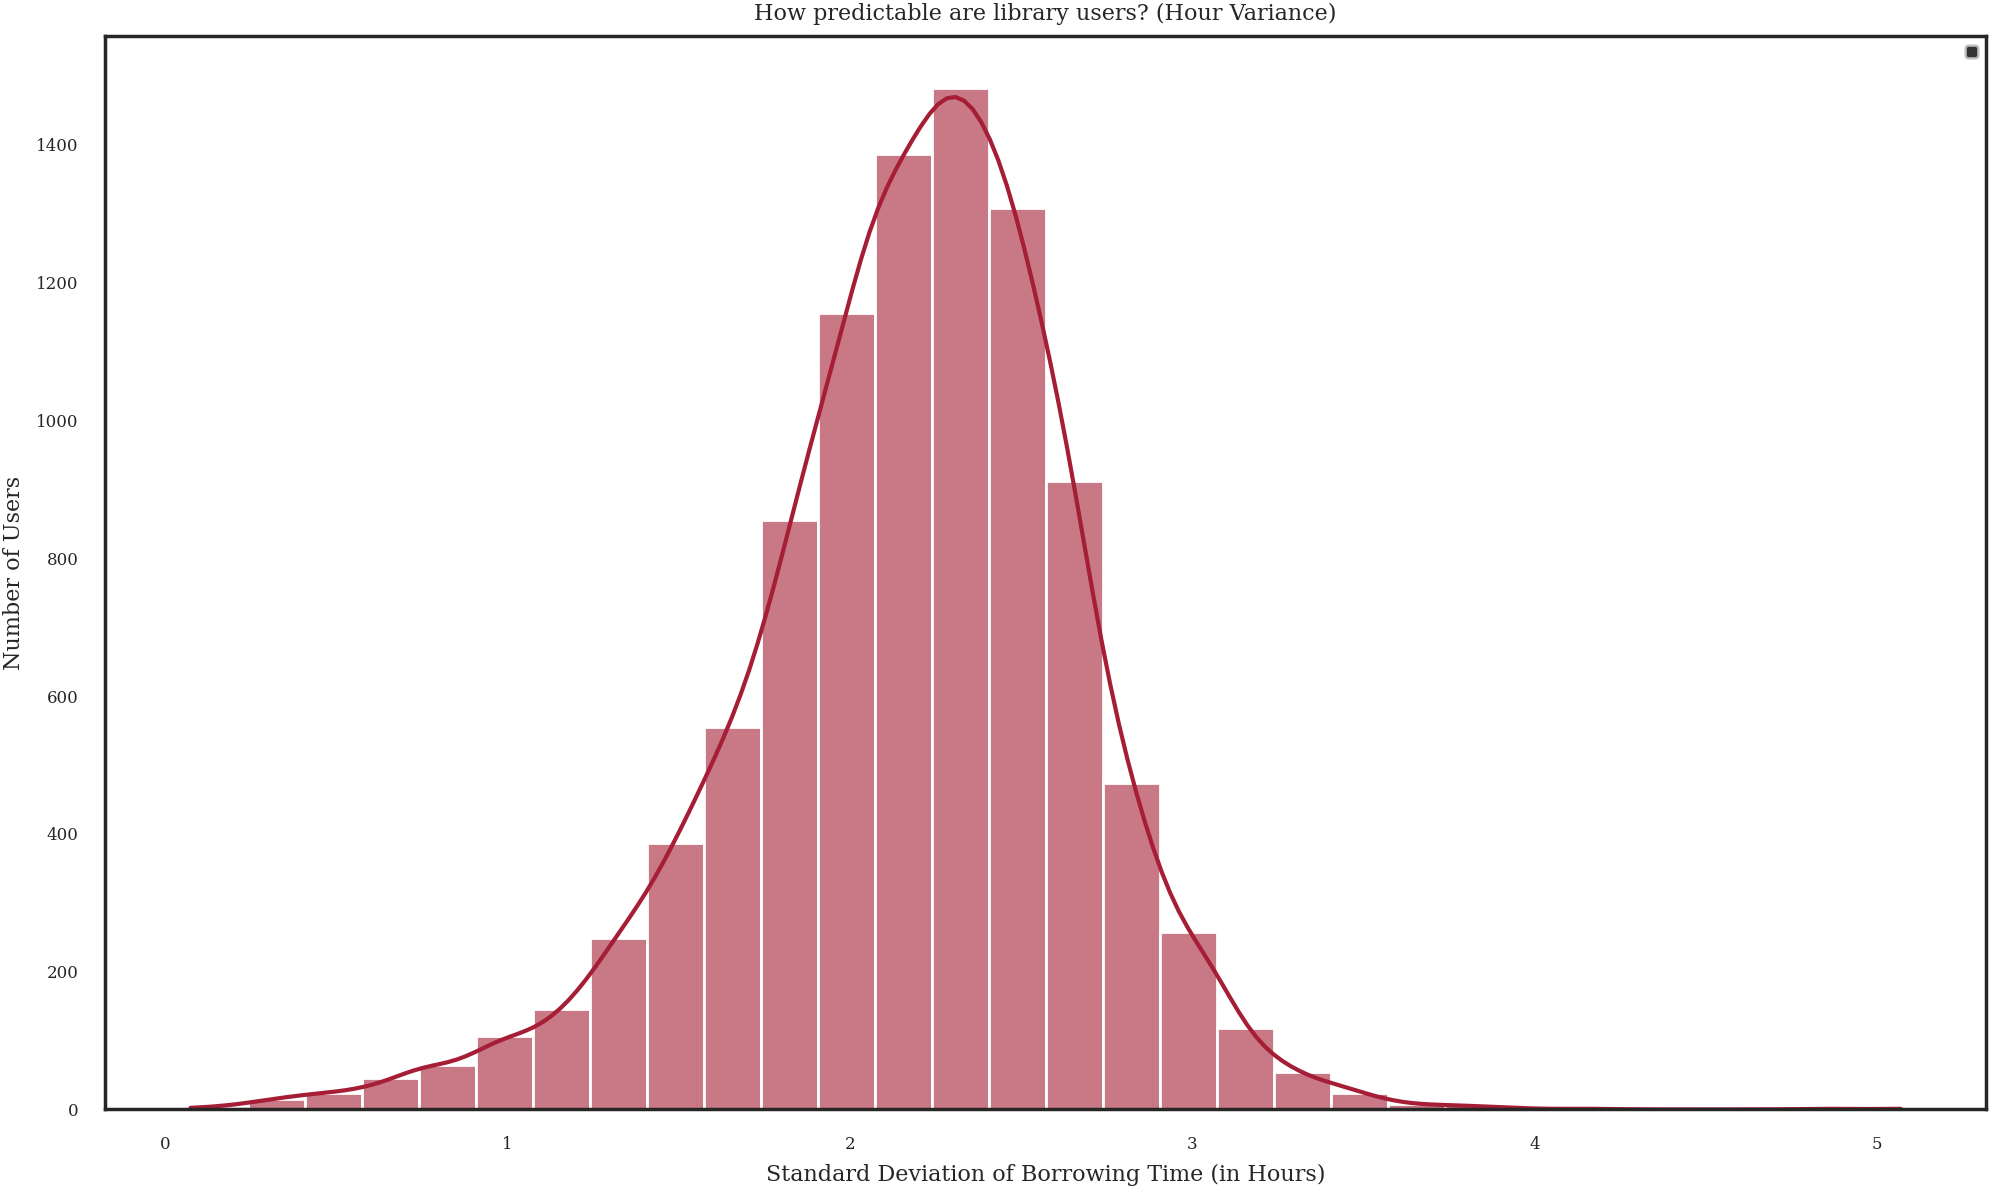

2.2% of users show high routine (±1 hour).
3.3% of users arrive at completely different times (>3h spread).


In [218]:
# Users with std = 0 are people who came exactly DAY times at exactly the same hour 
plt.figure(figsize=(10, 6))

sns.histplot(user_time_behavior['hour_spread'], bins=30, kde=True, alpha=0.6)

plt.title("How predictable are library users? (Hour Variance)")
plt.xlabel("Standard Deviation of Borrowing Time (in Hours)")
plt.ylabel("Number of Users")
plt.legend()
plt.show()

low_var = (user_time_behavior['hour_spread'] <= 1.0).sum() / len(user_time_behavior['hour_spread']) * 100
high_var = (user_time_behavior['hour_spread'] > 3.0).sum() / len(user_time_behavior['hour_spread']) * 100

print(f"{low_var:.1f}% of users show high routine (±1 hour).")
print(f"{high_var:.1f}% of users arrive at completely different times (>3h spread).")

### How does the standard deviation behave over the day? 

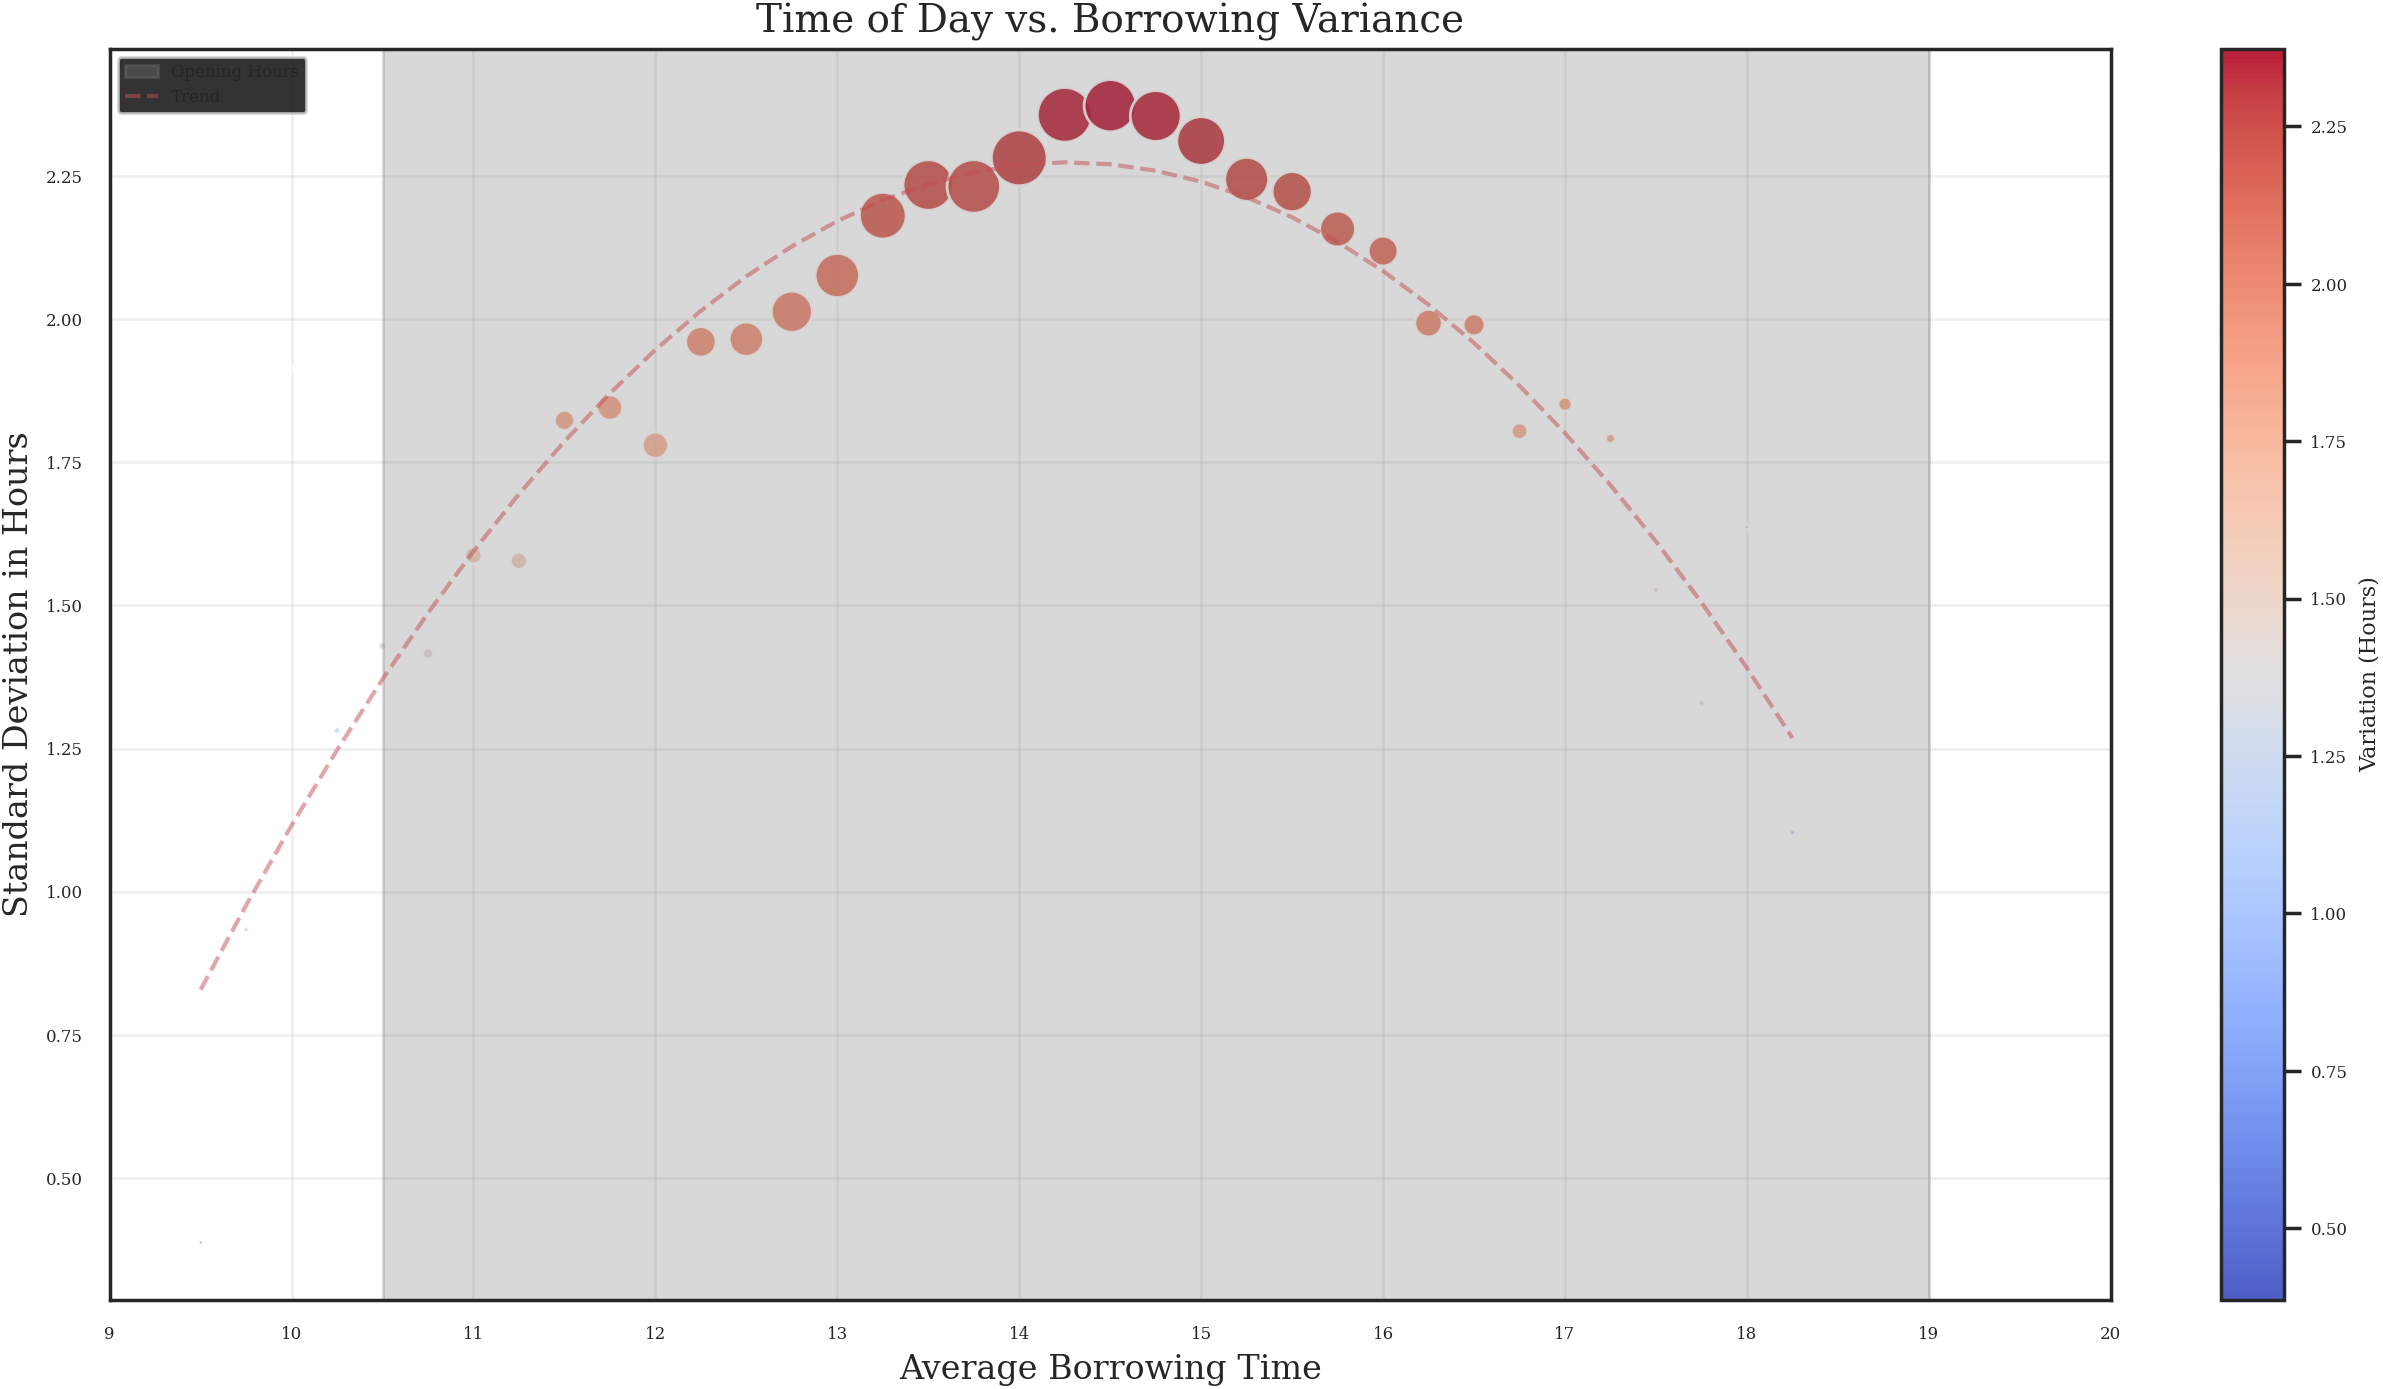

In [219]:


# Round average hour to 15-minute intervals (0.25h) for grouping
user_time_behavior['hour_bin'] = (user_time_behavior['avg_hour'] * 4).round() / 4

# Aggregate by time bin
stability_map = user_time_behavior.groupby('hour_bin').agg({
    'hour_spread': 'mean',
    'visit_count': 'count'
}).reset_index()

# Filter for relevant operational hours
stability_map = stability_map[(stability_map['hour_bin'] >= 9) & (stability_map['hour_bin'] <= 20)]

plt.figure(figsize=(12, 7))

# Create scatter plot: size = user volume, color = variance
scatter = plt.scatter(
    x=stability_map['hour_bin'],
    y=stability_map['hour_spread'],
    s=stability_map['visit_count'] * 0.5,
    c=stability_map['hour_spread'],
    cmap='coolwarm',
    alpha=0.9,
    edgecolors='w'
)

plt.axvspan(10.5, 19.0, color='gray', alpha=0.3, label='Opening Hours')

# Add polynomial trend line (degree 2)
z = np.polyfit(stability_map['hour_bin'], stability_map['hour_spread'], 2)
p = np.poly1d(z)
plt.plot(stability_map['hour_bin'], p(stability_map['hour_bin']), "r--", alpha=0.5, label='Trend')

plt.title("Time of Day vs. Borrowing Variance", fontsize=14)
plt.xlabel("Average Borrowing Time", fontsize=12)
plt.ylabel("Standard Deviation in Hours", fontsize=12)
plt.xticks(range(9, 21))
plt.grid(axis='both', alpha=0.3)
plt.colorbar(scatter, label='Variation (Hours)')
plt.legend()

plt.show()

## User segmentation: Combining the two findings: consistency in the day (how confidently does a user visit on the same day) and how high is the Standard Deviation of borrowing time

9637


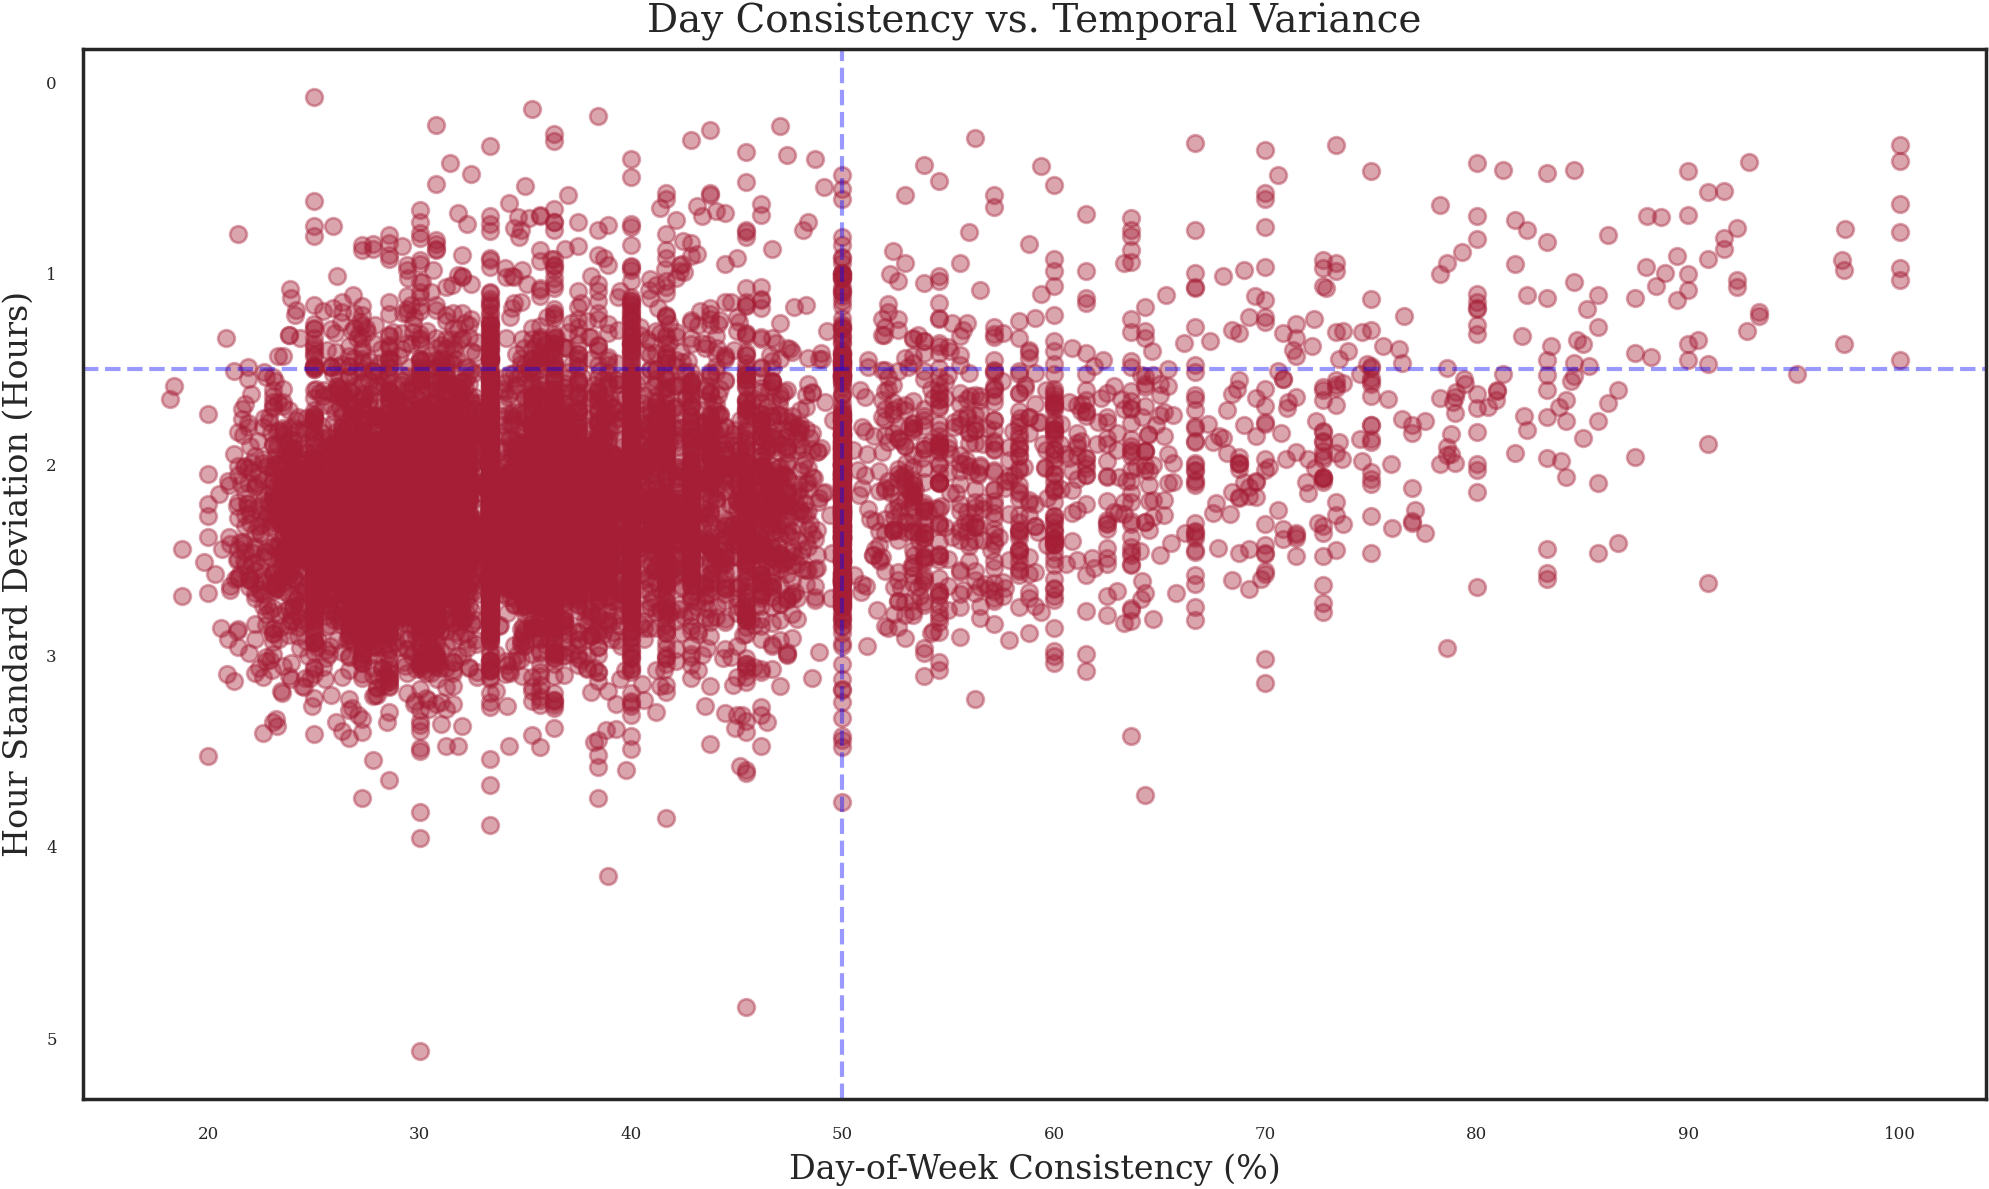

In [220]:

cluster_df = user_time_behavior[['avg_hour', 'hour_spread', 'visit_count']].copy()
cluster_df = user_time_behavior[user_time_behavior['visit_count'] >= MIN_SESSIONS].copy()
cluster_df['day_consistency'] = clean_consistency 

print(len(cluster_df))

plt.figure(figsize=(10, 6))

scatter = plt.scatter(
    x=cluster_df['day_consistency'], 
    y=cluster_df['hour_spread'],
    alpha=0.4
)

plt.axvline(x=50, color='blue', linestyle='--', alpha=0.4) # 50% Day-Consistency
plt.axhline(y=1.5, color='blue', linestyle='--', alpha=0.4) # 1.5h Standard Deviation

plt.title("Day Consistency vs. Temporal Variance", fontsize=14)
plt.xlabel("Day-of-Week Consistency (%)", fontsize=12)
plt.ylabel("Hour Standard Deviation (Hours)", fontsize=12)
plt.gca().invert_yaxis() 
                         
plt.show()

In [222]:

day_threshold = 50
time_threshold = 1.5

total_users = len(cluster_df)

top_right = cluster_df[(cluster_df['day_consistency'] >= day_threshold) & (cluster_df['hour_spread'] <= time_threshold)]
bottom_right = cluster_df[(cluster_df['day_consistency'] >= day_threshold) & (cluster_df['hour_spread'] > time_threshold)]
top_left = cluster_df[(cluster_df['day_consistency'] < day_threshold) & (cluster_df['hour_spread'] <= time_threshold)]
bottom_left = cluster_df[(cluster_df['day_consistency'] < day_threshold) & (cluster_df['hour_spread'] > time_threshold)]

# Print results
print(f"Total Users (n >= {MIN_SESSIONS}): {total_users}\n")
print(f"1. Top Right:    {len(top_right)} ({len(top_right)/total_users:.1%})")
print(f"2. Bottom Right: {len(bottom_right)} ({len(bottom_right)/total_users:.1%})")
print(f"3. Top Left:  {len(top_left)} ({len(top_left)/total_users:.1%})")
print(f"4. Bottom Left:   {len(bottom_left)} ({len(bottom_left)/total_users:.1%})")

Total Users (n >= 10): 9637

1. Top Right:    278 (2.9%)
2. Bottom Right: 1152 (12.0%)
3. Top Left:  566 (5.9%)
4. Bottom Left:   7578 (78.6%)
